In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pydicom as dicom
import os
from scipy import ndimage as ndi 
from skimage import morphology
from skimage.morphology import skeletonize
from skimage.feature import canny
from skimage.future import graph
from skimage.segmentation import clear_border
from scipy import stats
from skimage import filters

In [2]:
data_path = 'C:/Users/user/Desktop/Python/manekin'
output_path = 'C:/Users/user/Desktop/Python/nii/manekin'

In [3]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [5]:
#Save 3D CT image
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
np.save(output_path + "/3D_Manekin_image.npy", imgs)

In [6]:
#Load 3D CT image
CT_array = np.load(output_path+'/3D_Manekin_image.npy')

In [7]:
def sample_stack(stack, rows=10, cols=10, start_with=1, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

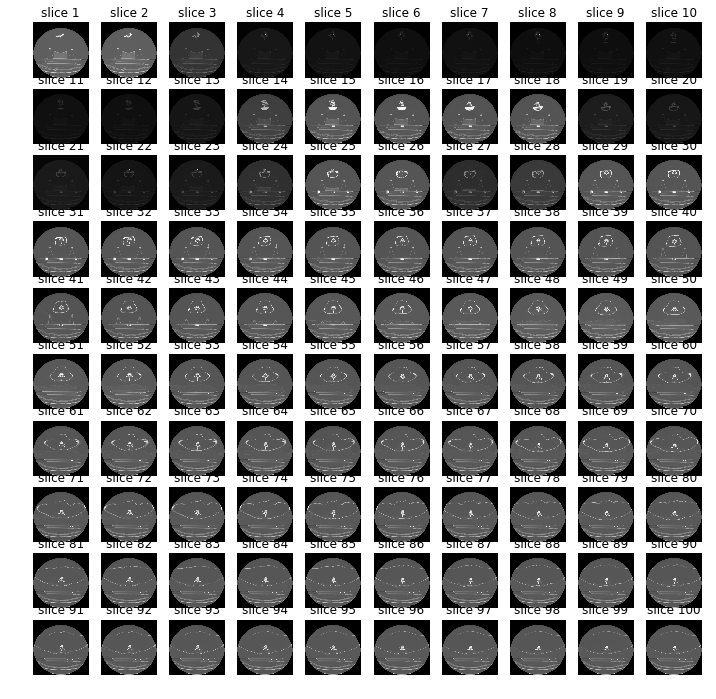

In [8]:
sample_stack(CT_array)

In [28]:
def generate_markers(image):
    
    #image Binary
    r_binary = image > -700
    binary = image < -700
    spine_b = image > 300
    
    ret,thresh1 = cv2.threshold(image,-700,1,cv2.THRESH_BINARY)
    kernel1 = np.ones((5,5),np.uint8)
    erosion1 = cv2.erode(thresh1, kernel1,iterations = 1)
    opening = cv2.morphologyEx(erosion1, cv2.MORPH_OPEN, kernel1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel1)
    
    ret,thresh2 = cv2.threshold(image,300,1,cv2.THRESH_BINARY)
    kernel2 = np.ones((2,2),np.uint8)  #kernel의 크기가 커질수록 많은 data를 잃음
    erosion2 = cv2.erode(thresh2, kernel2,iterations = 1)
    
    
    #remove
    #remove = ndi.label(r_binary)
    #opening = morphology.binary_opening(r_binary)
    #cleared = morphology.binary_closing(opening)
    
    #Boundary Image
    #clear = clear_border(binary)
    #remove = morphology.remove_small_objects(binary, 100)
    #delet = filters.threshold_li(r_binary)
    
    
    #erosion = morphology.binary_erosion(delet)

    
    #Filling Hole
    #boundary = cv2.Canny(closing, 10, 20)
    #filling = ndi.binary_fill_holes(boundary)
    #fii = ndi.binary_fill_holes(binary)
    
    #Skeletonization Image
    #edge_image = canny(filling, sigma=1) 
    #skeletonize_image = skeletonize(edge_image)
    

    return r_binary, binary, spine_b, closing, erosion2

In [10]:
r_binary, binary, spine_b, closing, erosion2 = generate_markers(CT_array)

In [11]:
from skimage import measure

In [12]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

In [13]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]])

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [14]:
import scipy.ndimage

In [15]:
print ("Shape before resampling\t", spine_b.shape)
CT_array, spacing = resample(spine_b, patient, [1,1,1])
print ("Shape after resampling\t", CT_array.shape)

Shape before resampling	 (397, 512, 512)
Shape after resampling	 (794, 500, 500)


In [16]:
v,f = make_mesh(CT_array,0,2)

Transposing surface
Calculating surface


In [17]:
x = v[:,2]
x = 505 - x
v[:,2] = x

In [18]:
from open3d import *
import copy

In [19]:
skeleton_data = PointCloud()
skeleton_data.points = Vector3dVector(v)

In [20]:
write_point_cloud(output_path + "/spine_thresh_from_Manekin.ply", skeleton_data)
skeleton_data = read_point_cloud(output_path + "/spine_thresh_from_Manekin.ply")
draw_geometries([skeleton_data])

In [21]:
skeleton_data.paint_uniform_color([0.85, 0.65, 0.12])
draw_geometries([skeleton_data])

In [22]:
print ("Shape before resampling\t", erosion2.shape)
CT_array, spacing = resample(erosion2, patient, [1,1,1])
print ("Shape after resampling\t", CT_array.shape)

Shape before resampling	 (397, 512, 512)
Shape after resampling	 (794, 500, 500)


In [23]:
v,f = make_mesh(CT_array,0,2)

Transposing surface
Calculating surface


In [24]:
x = v[:,2]
x = 505 - x
v[:,2] = x

In [25]:
skeleton_data = PointCloud()
skeleton_data.points = Vector3dVector(v)

In [26]:
write_point_cloud(output_path + "/spine_erosion_from_Manekin.ply", skeleton_data)
skeleton_data = read_point_cloud(output_path + "/spine_erosion_from_Manekin.ply")
draw_geometries([skeleton_data])

In [27]:
skeleton_data.paint_uniform_color([0.85, 0.65, 0.12])
draw_geometries([skeleton_data])

In [ ]:
# 사람부분만 신경쓰고 있어서 마네킹은 처음 시도해봤는데.. 침상부터 제거가 제대로 되지않아 더욱 수정해야할것 같습니다..